In [4]:
"""
Created on Sun Mar 24 17:51:08 2019

@author: aamir-mustafa
Modified by: Pankhuri Vanjani
"""
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from resnet_model import *  # Imports the ResNet Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import numpy as np
import pandas as pd
import cv2


"""
Adversarial Attack Options: fgsm, bim, mim, pgd
"""

'\nAdversarial Attack Options: fgsm, bim, mim, pgd\n'

In [5]:
num_classes=10

model = resnet(num_classes=num_classes,depth=110)
if True:
    model = nn.DataParallel(model).cuda()
    
#Loading Trained Model
softmax_filename= 'CIFAR10_Softmax.pth.tar'    
filename= 'CIFAR10_PCL_AdvTrain_FGSM.pth.tar' 
robust_model= 'robust_model.pth.tar'

checkpoint = torch.load(softmax_filename)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [53]:
transform_test = transforms.Compose([transforms.ToTensor(),])


class ImageDataset(Dataset):
  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
     
    self.image_names=self.csv[:]['id']
    #self.image_names=self.csv[:,0]

    self.labels=np.array(self.csv.drop(['id', 'label'], axis=1))
    #self.labels = np.array(self.csv[:,1])
   
#The __len__ function returns the number of samples in our dataset.
  def __len__(self):
    return len(self.image_names)
 
  def __getitem__(self,index):
     
    #image=cv2.imread(self.img_folder+str(self.image_names.iloc[index])+'.png')
    image = Image.open(self.img_folder +'/'+ str(int(self.image_names.iloc[index])) + '_adv.png')

    #image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
 
    image=self.transform(image)
    targets=self.labels[index]
    if targets == 'airplane':
        targets[index] = 1
    elif targets == 'automobile':
        targets[index] = 2
    elif targets == 'bird':
        targets[index] = 3
    elif targets == 'cat':  
        targets[index] = 4
    elif targets == 'deer':
        targets[index] = 5
    elif targets == 'dog':
        targets[index] = 6
    elif targets == 'frog':
        targets[index] = 7
    elif targets == 'horse':
        targets[index] = 8
    elif targets == 'ship':
        targets[index] = 9
    elif targets == 'truck':
        targets[index] = 10
    #targets=targets.astype(int)
    sample = {'image': image,'labels':targets}
 
    return sample

In [54]:
test_set = pd.read_csv('test.csv')
test_dataset=ImageDataset(test_set,'adver_Folder',transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)



In [23]:
# Mean and Standard Deiation of the Dataset
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
def normalize(t):
    t[:, 0, :, :] = (t[:, 0, :, :] - mean[0])/std[0]
    t[:, 1, :, :] = (t[:, 1, :, :] - mean[1])/std[1]
    t[:, 2, :, :] = (t[:, 2, :, :] - mean[2])/std[2]

    return t
def un_normalize(t):
    t[:, 0, :, :] = (t[:, 0, :, :] * std[0]) + mean[0]
    t[:, 1, :, :] = (t[:, 1, :, :] * std[1]) + mean[1]
    t[:, 2, :, :] = (t[:, 2, :, :] * std[2]) + mean[2]

    return t

In [33]:
# Attacking Images batch-wise
def attack(model, criterion, img, label, eps, attack_type, iters):
    adv = img.detach()
    adv.requires_grad = True

    if attack_type == 'fgsm':
        iterations = 1
    else:
        iterations = iters

    if attack_type == 'pgd':
        step = 2 / 255
    else:
        step = eps / iterations
        
        noise = 0
        
    for j in range(iterations):
        _,_,_,out_adv = model(normalize(adv.clone()))
        loss = criterion(out_adv, label)
        loss.backward()

        if attack_type == 'mim':
            adv_mean= torch.mean(torch.abs(adv.grad), dim=1,  keepdim=True)
            adv_mean= torch.mean(torch.abs(adv_mean), dim=2,  keepdim=True)
            adv_mean= torch.mean(torch.abs(adv_mean), dim=3,  keepdim=True)
            adv.grad = adv.grad / adv_mean
            noise = noise + adv.grad
        else:
            noise = adv.grad

        # Optimization step
        adv.data = adv.data + step * noise.sign()
#        adv.data = adv.data + step * adv.grad.sign()

        if attack_type == 'pgd':
            adv.data = torch.where(adv.data > img.data + eps, img.data + eps, adv.data)
            adv.data = torch.where(adv.data < img.data - eps, img.data - eps, adv.data)
        adv.data.clamp_(0.0, 1.0)

        adv.grad.data.zero_()

    return adv.detach()

In [30]:
# Loss Criteria
criterion = nn.CrossEntropyLoss()
adv_acc = 0
clean_acc = 0
eps =8/255 # Epsilon for Adversarial Attack

In [55]:
output_labels=[]
for i, (img, label) in enumerate(test_loader):
    output_labels.append(label)
    

<ipython-input-53-20d1d97d44d5>:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if targets == 'airplane':
<ipython-input-53-20d1d97d44d5>:31: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif targets == 'automobile':
<ipython-input-53-20d1d97d44d5>:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if targets == 'airplane':


In [30]:
output_labels

[tensor([3]),
 tensor([8]),
 tensor([8]),
 tensor([0]),
 tensor([6]),
 tensor([6]),
 tensor([1]),
 tensor([6]),
 tensor([3]),
 tensor([1]),
 tensor([0]),
 tensor([9]),
 tensor([5]),
 tensor([7]),
 tensor([9]),
 tensor([8]),
 tensor([5]),
 tensor([7]),
 tensor([8]),
 tensor([6]),
 tensor([7]),
 tensor([0]),
 tensor([4]),
 tensor([9]),
 tensor([5]),
 tensor([2]),
 tensor([4]),
 tensor([0]),
 tensor([9]),
 tensor([6]),
 tensor([6]),
 tensor([5]),
 tensor([4]),
 tensor([5]),
 tensor([9]),
 tensor([2]),
 tensor([4]),
 tensor([1]),
 tensor([9]),
 tensor([5]),
 tensor([4]),
 tensor([6]),
 tensor([5]),
 tensor([6]),
 tensor([0]),
 tensor([9]),
 tensor([3]),
 tensor([9]),
 tensor([7]),
 tensor([6]),
 tensor([9]),
 tensor([8]),
 tensor([0]),
 tensor([3]),
 tensor([8]),
 tensor([8]),
 tensor([7]),
 tensor([7]),
 tensor([4]),
 tensor([6]),
 tensor([7]),
 tensor([3]),
 tensor([6]),
 tensor([3]),
 tensor([6]),
 tensor([2]),
 tensor([1]),
 tensor([2]),
 tensor([3]),
 tensor([7]),
 tensor([2]),
 tenso

In [31]:
features_extracted_clean = []
features_extracted_adv = []
outputs_labels = []

count = 0
for i, (img, label) in enumerate(test_loader):
    img, label = img.to(device), label.to(device)
    

    #extract features from last layer of model in variable features_extracted 
    feats1024 = model(normalize(img))[2]

    #extract labels from last layer of model in variable outputs_labels
    features_extracted_clean.append(feats1024.reshape(len(img),-1).detach().cpu().numpy())


    #Attack 
    if count%100==0:     
        print('Batch: {0}'.format(i))
    count = count +1


Batch: 0
Batch: 100
Batch: 200
Batch: 300
Batch: 400
Batch: 500
Batch: 600
Batch: 700
Batch: 800
Batch: 900
Batch: 1000
Batch: 1100
Batch: 1200
Batch: 1300
Batch: 1400
Batch: 1500
Batch: 1600
Batch: 1700
Batch: 1800
Batch: 1900
Batch: 2000
Batch: 2100
Batch: 2200
Batch: 2300
Batch: 2400
Batch: 2500
Batch: 2600
Batch: 2700
Batch: 2800
Batch: 2900
Batch: 3000
Batch: 3100
Batch: 3200
Batch: 3300
Batch: 3400
Batch: 3500
Batch: 3600
Batch: 3700
Batch: 3800
Batch: 3900
Batch: 4000
Batch: 4100
Batch: 4200
Batch: 4300
Batch: 4400
Batch: 4500
Batch: 4600
Batch: 4700
Batch: 4800
Batch: 4900
Batch: 5000
Batch: 5100
Batch: 5200
Batch: 5300
Batch: 5400
Batch: 5500
Batch: 5600
Batch: 5700
Batch: 5800
Batch: 5900
Batch: 6000
Batch: 6100
Batch: 6200
Batch: 6300
Batch: 6400
Batch: 6500
Batch: 6600
Batch: 6700
Batch: 6800
Batch: 6900
Batch: 7000
Batch: 7100
Batch: 7200
Batch: 7300
Batch: 7400
Batch: 7500
Batch: 7600
Batch: 7700
Batch: 7800
Batch: 7900
Batch: 8000
Batch: 8100
Batch: 8200
Batch: 8300
Batc

In [32]:
feats1024.shape

torch.Size([1, 1024])

In [33]:

features_extracted_clean[0].shape

(1, 1024)

In [34]:
print(len(outputs_labels))
print(len(test_loader))

0
10000


In [35]:
#Debug print statements

print('lenght, features clean',len(features_extracted_clean))

print('length,labels',len(output_labels))

lenght, features clean 10000
length,labels 10000


In [36]:
'''layer_label = np.hstack(outputs_labels)
print(len(layer_label))

print(len(outputs_labels))
'''

'layer_label = np.hstack(outputs_labels)\nprint(len(layer_label))\n\nprint(len(outputs_labels))\n'

In [37]:
feature_extracted=np.array(features_extracted_clean).reshape(10000,-1)
output_labels=np.array(output_labels).reshape(10000,1)
embedding_data = TSNE().fit_transform(feature_extracted)

<ipython-input-37-7f97b3058fba>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output_labels=np.array(output_labels).reshape(10000,1)
<ipython-input-37-7f97b3058fba>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output_labels=np.array(output_labels).reshape(10000,1)
/home/pankhuri/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

In [38]:
output_labels=np.array(output_labels).reshape(10000,1)
output_labels=list(output_labels.reshape(10000,))

In [39]:
output_labels

[tensor([3]),
 tensor([8]),
 tensor([8]),
 tensor([0]),
 tensor([6]),
 tensor([6]),
 tensor([1]),
 tensor([6]),
 tensor([3]),
 tensor([1]),
 tensor([0]),
 tensor([9]),
 tensor([5]),
 tensor([7]),
 tensor([9]),
 tensor([8]),
 tensor([5]),
 tensor([7]),
 tensor([8]),
 tensor([6]),
 tensor([7]),
 tensor([0]),
 tensor([4]),
 tensor([9]),
 tensor([5]),
 tensor([2]),
 tensor([4]),
 tensor([0]),
 tensor([9]),
 tensor([6]),
 tensor([6]),
 tensor([5]),
 tensor([4]),
 tensor([5]),
 tensor([9]),
 tensor([2]),
 tensor([4]),
 tensor([1]),
 tensor([9]),
 tensor([5]),
 tensor([4]),
 tensor([6]),
 tensor([5]),
 tensor([6]),
 tensor([0]),
 tensor([9]),
 tensor([3]),
 tensor([9]),
 tensor([7]),
 tensor([6]),
 tensor([9]),
 tensor([8]),
 tensor([0]),
 tensor([3]),
 tensor([8]),
 tensor([8]),
 tensor([7]),
 tensor([7]),
 tensor([4]),
 tensor([6]),
 tensor([7]),
 tensor([3]),
 tensor([6]),
 tensor([3]),
 tensor([6]),
 tensor([2]),
 tensor([1]),
 tensor([2]),
 tensor([3]),
 tensor([7]),
 tensor([2]),
 tenso

In [40]:
embedding_data.shape

(10000, 2)

/home/pankhuri/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)


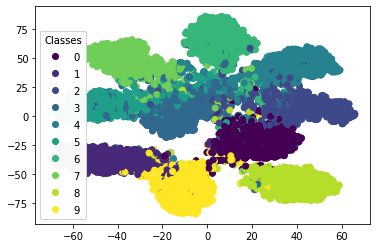

<class 'numpy.ndarray'>


In [41]:
cifar_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def plot_embedding(data, label, title):
   

    fig, ax = plt.subplots()
   
    scatter=ax.scatter(data[:, 0], data[:, 1],c=label)
    #plt.savefig(img_title, dpi=300)
  
    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
    ax.add_artist(legend1)
    plt.show()
plot_embedding(embedding_data, output_labels, 'softmax_adv_cifar10_adv_v0')
#print length of embedding_data
print(type(embedding_data))